In [1]:
#pip install imblearn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from abc import ABC, abstractmethod
import numpy as np
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, label_binarize
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE, f_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, precision_recall_curve,recall_score
from sklearn.inspection import PartialDependenceDisplay
from warnings import filterwarnings
import joblib
from collections import Counter
import os
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

In [3]:
class DataLoader(ABC):

    @abstractmethod
    def load_data(self):
        pass

    def _clean_data(self, df):
        """ENCAPSULATION: A protected method for internal cleaning steps."""
        df.columns = [col.lower().replace(' ', '_') for col in df.columns]

        print("Basic cleaning applied.")
        return df

class WineCleanCSVLoader(DataLoader):

    def __init__(self, filepath, target_col="quality", sep=','):
        self.filepath = filepath
        self.target_col = target_col
        self.sep = sep  # <-- store separator

    def load_data(self):
        df = pd.read_csv(self.filepath, sep=self.sep)
        print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns from {self.filepath}")
        df = self._clean_data(df)
        return df

In [4]:
loader = WineCleanCSVLoader(filepath="../data/processed/winequality_with_quality_category.csv", sep=',', target_col="quality_category")
wine_pro = loader.load_data()
wine_pro.head()

Loaded 1599 rows and 16 columns from ../data/processed/winequality_with_quality_category.csv
Basic cleaning applied.


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,quality_category,so2_ratio,acid_alcohol_balance,sugar_acid_ratio
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0,1.0,0.314286,13.409415,0.256722
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0,1.0,0.367647,11.123723,0.333291
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0,1.0,0.272727,12.877792,0.294834
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0,1.0,0.278689,34.875445,0.169628
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0,1.0,0.314286,13.409415,0.256722


In [5]:
n_samples = wine_pro.shape[0]

In [8]:
feature_cols = [
    c for c in wine_pro.columns
    if c not in ["quality", "quality_category", "quality_label"]
]
n_features = len(feature_cols)

print("Total samples:", n_samples)
print("Number of features:", n_features)

Total samples: 1599
Number of features: 14


In [9]:
# 4. Class counts for quality_category
class_counts = wine_pro["quality_category"].value_counts().sort_index()

label_map = {0: "Low", 1: "Medium", 2: "High"}

for k, v in class_counts.items():
    print(f"{label_map[k]} ({k}): {v} samples")

Low (0.0): 53 samples
Medium (1.0): 1319 samples
High (2.0): 199 samples


In [10]:
class_pct = (class_counts / n_samples) * 100

for k, v in class_counts.items():
    print(f"{label_map[k]} ({k}): {v} samples ({class_pct[k]:.1f}%)")

Low (0.0): 53 samples (3.3%)
Medium (1.0): 1319 samples (82.5%)
High (2.0): 199 samples (12.4%)


In [6]:
# Then split into X and y
X = wine_pro.drop(columns=["quality", "quality_category"])  # or keep "quality" if needed
y = wine_pro["quality_category"]

# Ensure no NaNs
mask = ~y.isna()
X = X[mask]
y = y[mask]

In [6]:
## Stratified split to maintain the same proportion of 'low'/'Medium , High' quality in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print("-" * 50)

X_train shape: (1256, 14)
X_test shape: (315, 14)
--------------------------------------------------


In [7]:
#Introducing polynomial features + which model gets polynomial features beacuse only linear models will get polynomial features
SEED = 42
models = {
    "LogReg": LogisticRegression(multi_class="multinomial", max_iter=800, random_state=SEED),
    "Ridge":  RidgeClassifier(random_state=SEED),
    "RF":     RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=SEED),
    "GBDT":   GradientBoostingClassifier(random_state=SEED),
    "SVM":    SVC(kernel="rbf", probability=False, random_state=SEED),
    "KNN":    KNeighborsClassifier(n_neighbors=11),
}

# Only truly linear models benefit from poly here
poly_ok = {"LogReg": True, "Ridge": True, "RF": False, "GBDT": False, "SVM": False, "KNN": False}


In [8]:
#Pipeline
K_TOP = 8  

def make_poly_selector_pipeline(estimator, selector="anova", use_poly=False, degree=2):
    steps = []
    if use_poly:
        # interaction_only=True is often cleaner for linear models
        steps.append(("poly", PolynomialFeatures(degree=degree, include_bias=False, interaction_only=True)))
    if selector == "anova":
        steps.append(("sel", SelectKBest(score_func=f_classif, k=K_TOP)))
    elif selector == "mi":
        steps.append(("sel", SelectKBest(score_func=mutual_info_classif, k=K_TOP)))
    else:
        raise ValueError("selector must be 'anova' or 'mi'")
    steps += [
        ("scaler", StandardScaler()),
        ("smote", SMOTE(sampling_strategy="auto", random_state=SEED)),
        ("clf", estimator),
    ]
    return ImbPipeline(steps)

In [9]:
#Model and Selector Comparison with cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

rows = []
for name, est in models.items():
    for selector in ["anova", "mi"]:
        pipe = make_poly_selector_pipeline(
            estimator=est,
            selector=selector,
            use_poly=poly_ok[name],
            degree=2
        )
        scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1_macro", n_jobs=-1)
        rows.append({
            "model": name, "selector": selector,
            "cv_macro_f1_mean": scores.mean(), "cv_macro_f1_std": scores.std()
        })

cv_tbl = pd.DataFrame(rows).sort_values("cv_macro_f1_mean", ascending=False).reset_index(drop=True)
cv_tbl.round(3)

,model,selector,cv_macro_f1_mean,cv_macro_f1_std
0,RF,anova,0.533,0.027
1,RF,mi,0.514,0.025
2,GBDT,mi,0.490,0.017
3,GBDT,anova,0.487,0.033
4,SVM,mi,0.454,0.030
5,SVM,anova,0.450,0.025
6,KNN,mi,0.421,0.014
7,KNN,anova,0.420,0.027
8,LogReg,mi,0.418,0.029
9,LogReg,anova,0.414,0.034


In [10]:
cv_tbl.to_csv("metricscompareformodels.csv")

In [11]:
#From the table we can tell Randomn forest plus anova won

Champion (CV): RF | selector: anova


,accuracy,macro_f1,weighted_f1,macro_precision,macro_recall,f1_class_0,f1_class_1,f1_class_2
0,0.794,0.529,0.808,0.506,0.572,0.154,0.873,0.56



Classification report
               precision    recall  f1-score   support

         Low      0.133     0.182     0.154        11
      Medium      0.917     0.833     0.873       264
        High      0.467     0.700     0.560        40

    accuracy                          0.794       315
   macro avg      0.506     0.572     0.529       315
weighted avg      0.832     0.794     0.808       315



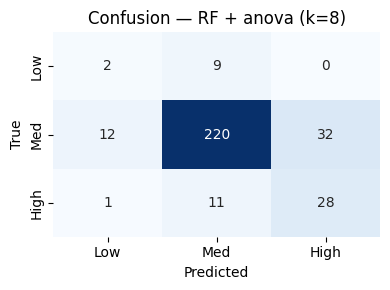

In [12]:
#Using the best model on full training set plus evaluation
best_row = cv_tbl.iloc[0]
best_name     = best_row["model"]
best_selector = best_row["selector"]
print("Champion (CV):", best_name, "| selector:", best_selector)

champ = make_poly_selector_pipeline(
    estimator=models[best_name],
    selector=best_selector,
    use_poly=poly_ok[best_name],
    degree=2
)
champ.fit(X_train, y_train)
y_pred = champ.predict(X_test)

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "macro_f1": f1_score(y_test, y_pred, average="macro"),
    "weighted_f1": f1_score(y_test, y_pred, average="weighted"),
    "macro_precision": precision_score(y_test, y_pred, average="macro", zero_division=0),
    "macro_recall": recall_score(y_test, y_pred, average="macro", zero_division=0),
}
for c, f1c in zip([0,1,2], f1_score(y_test, y_pred, average=None, labels=[0,1,2])):
    metrics[f"f1_class_{c}"] = float(f1c)

display(pd.DataFrame([metrics]).round(3))
print("\nClassification report\n",
      classification_report(y_test, y_pred, digits=3, target_names=["Low","Medium","High"]))

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low','Med','High'], yticklabels=['Low','Med','High'])
plt.title(f"Confusion — {best_name} + {best_selector} (k={K_TOP})")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

In [13]:
#Low stays week trying smoteen to remove overlapping samples after oversampling
SEED = 42
K_TOP = 8

def make_rf_anova_smoteenn():
    return ImbPipeline([
        ("sel", SelectKBest(score_func=f_classif, k=K_TOP)),
        ("scaler", StandardScaler()),
        ("smoteenn", SMOTEENN(random_state=SEED)),
        ("clf", RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=SEED)),
    ])

rf_smoteenn = make_rf_anova_smoteenn()
rf_smoteenn.fit(X_train, y_train)
y_pred = rf_smoteenn.predict(X_test)

print("RF + ANOVA + SMOTEENN")
print(classification_report(y_test, y_pred, target_names=["Low","Medium","High"]))
print(confusion_matrix(y_test, y_pred, labels=[0,1,2]))


RF + ANOVA + SMOTEENN
              precision    recall  f1-score   support

         Low       0.13      0.36      0.19        11
      Medium       0.94      0.67      0.78       264
        High       0.35      0.82      0.49        40

    accuracy                           0.68       315
   macro avg       0.47      0.62      0.49       315
weighted avg       0.83      0.68      0.73       315

[[  4   6   1]
 [ 26 178  60]
 [  1   6  33]]


In [14]:
#Lets oversample low more than others
cnt = Counter(y_train)
maj = max(cnt.values())
# Oversample "Low" (0) aggressively; keep others closer to original
target_counts = {0: int(0.9*maj), 1: cnt[1], 2: cnt[2]}  
def make_rf_anova_custom_smote():
    return ImbPipeline([
        ("sel", SelectKBest(score_func=f_classif, k=K_TOP)),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(sampling_strategy=target_counts, random_state=SEED)),
        ("clf", RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=SEED)),
    ])

rf_csmote = make_rf_anova_custom_smote()
rf_csmote.fit(X_train, y_train)
print("RF + ANOVA + Custom SMOTE")
print(classification_report(y_test, rf_csmote.predict(X_test), target_names=["Low","Medium","High"]))

RF + ANOVA + Custom SMOTE
              precision    recall  f1-score   support

         Low       0.14      0.18      0.16        11
      Medium       0.90      0.92      0.91       264
        High       0.68      0.53      0.59        40

    accuracy                           0.84       315
   macro avg       0.57      0.54      0.55       315
weighted avg       0.85      0.84      0.84       315



In [15]:
#Lets try Balancing Random Forest
def make_brf_anova():
    return ImbPipeline([
        ("sel", SelectKBest(score_func=f_classif, k=K_TOP)),
        ("scaler", StandardScaler()),
        ("clf", BalancedRandomForestClassifier(
            n_estimators=400, sampling_strategy="auto", random_state=SEED, n_jobs=-1
        )),
    ])

brf = make_brf_anova()
brf.fit(X_train, y_train)
print("BalancedRandomForest + ANOVA")
print(classification_report(y_test, brf.predict(X_test), target_names=["Low","Medium","High"]))

BalancedRandomForest + ANOVA
              precision    recall  f1-score   support

         Low       0.08      0.64      0.15        11
      Medium       0.92      0.51      0.66       264
        High       0.36      0.78      0.50        40

    accuracy                           0.55       315
   macro avg       0.46      0.64      0.43       315
weighted avg       0.82      0.55      0.62       315



In [17]:
#Lets try Calibrating probabilty (which is a practical boost to low recall)
# Start from your best-performing RF+ANOVA (plain SMOTE is fine or SMOTEENN if it looked better)
# Build the full estimator to be calibrated (so all steps refit inside CV folds)
rf_estimator = ImbPipeline([
    ("sel",   SelectKBest(score_func=f_classif, k=K_TOP)),
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=SEED)),
    ("clf",   RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=SEED)),
])

# Calibrate the whole estimator (multiclass OVR by default)
calibrated = CalibratedClassifierCV(
    estimator=rf_estimator,   # <- use 'estimator', not 'base_estimator'
    method="isotonic",        # or "sigmoid" (faster)
    cv=5
)

calibrated.fit(X_train, y_train)
probs = calibrated.predict_proba(X_test)

# ----- Cost-sensitive decisions (example) -----
# rows = true classes, cols = predicted classes
C = np.array([
    [0.0, 6.0, 8.0],   # true Low
    [3.0, 0.0, 2.0],   # true Medium
    [5.0, 3.5, 0.0],   # true High
])

exp_costs   = probs @ C
y_pred_cost = exp_costs.argmin(axis=1)

print("Cost-sensitive decisions (Bayes optimal wrt C)")
print(classification_report(y_test, y_pred_cost, target_names=["Low","Medium","High"]))
y_true = np.asarray(y_test, dtype=int)
y_pred = np.asarray(y_pred_cost, dtype=int)

sample_costs = C[y_true, y_pred]
print("Total expected cost:", sample_costs.sum())
print("Average cost per sample:", sample_costs.mean().round(3))

# (optional) per-class average cost
class_names = np.array(["Low","Medium","High"])
df_cost = pd.DataFrame({
    "true_class": class_names[y_true],
    "pred_class": class_names[y_pred],
    "cost": sample_costs
})
print("\nAverage cost by true class:")
print(df_cost.groupby("true_class")["cost"].mean().reindex(class_names).round(3))

Cost-sensitive decisions (Bayes optimal wrt C)
              precision    recall  f1-score   support

         Low       0.25      0.09      0.13        11
      Medium       0.90      0.93      0.91       264
        High       0.59      0.57      0.58        40

    accuracy                           0.85       315
   macro avg       0.58      0.53      0.54       315
weighted avg       0.84      0.85      0.84       315

Total expected cost: 160.5
Average cost per sample: 0.51

Average cost by true class:
true_class
Low       5.455
Medium    0.155
High      1.488
Name: cost, dtype: float64


In [18]:
# Scale class probabilities by per-class thresholds; lower thr for Low to favor recall
thr_grid = np.linspace(0.15, 0.40, 6)  
best = None

for t0 in thr_grid:
    thr = np.array([t0, 0.33, 0.33])   # tune only Low for simplicity
    scaled = probs / thr
    y_pred_thr = scaled.argmax(axis=1)

    macro_f1 = f1_score(y_test, y_pred_thr, average="macro")
    f1_low   = f1_score(y_test, y_pred_thr, average=None, labels=[0,1,2])[0]
    cand = (macro_f1, f1_low, t0)
    if (best is None) or (cand[0] > best[0]):  
        best = cand

print(f"Best threshold for Low: {best[2]:.2f} | macroF1={best[0]:.3f} | f1_low={best[1]:.3f}")

Best threshold for Low: 0.35 | macroF1=0.544 | f1_low=0.143


#Error-Handling & Imbalance Methods — Results Report
1) Setup & Baseline

Model: Random Forest + ANOVA(k=8) + StandardScaler + SMOTE(auto)
Test metrics (baseline):

Accuracy: 0.794 Macro-F1: 0.529 Weighted-F1: 0.808

Per-class: Low F1=0.154 (P=0.133, R=0.182) • Medium F1=0.873 (P=0.917, R=0.833) • High F1=0.560 (P=0.467, R=0.700)
Takeaway: High overall accuracy driven by Medium; Low remains poorly detected.

2) Methods Evaluated

A. SMOTEENN (oversample + Edited NN cleaning) within pipeline.

B. Custom SMOTE (targeted oversampling of Low) — raised Low count toward majority only.

C. Balanced Random Forest — class-balanced bootstrap per tree (no SMOTE).

D. Calibration + Cost-Sensitive Decisions — isotonic (or sigmoid) calibration, then Bayes decision using a cost matrix.

E. Threshold Tuning (Low only) — searched Low threshold to optimize macro-F1.

3) Results (vs. baseline)
Variant	Accuracy	Macro-F1	Weighted-F1	Low R	Low F1	Med R	High R
Baseline	0.794	0.529	0.808	0.182	0.154	0.833	0.700
A. SMOTEENN	0.680	0.490	0.730	0.360	0.190	0.670	0.820
B. Custom SMOTE	0.840	0.550	0.840	0.180	0.160	0.920	0.530
C. Balanced RF	0.550	0.430	0.620	0.640	0.150	0.510	0.780
D. Calib + Cost	0.850	0.540	0.840	0.090	0.130	0.930	0.570
E. Low threshold (t=0.35)	—	0.544	—	—	0.143	—	—

Confusion examples:

A (SMOTEENN): [[4,6,1],[26,178,60],[1,6,33]] — Low/High recalls rise; Medium recall drops.

B (Custom SMOTE): Strong Medium; High becomes conservative (precision↑/recall↓); Low unchanged.

C (Balanced RF): Aggressively flags Low (R=0.64) at large cost to overall accuracy.

D (Calibrated + Cost): Best overall accuracy; pushes ambiguous cases to Medium (Low recall falls).

4) Discussion & Trade-offs

A. SMOTEENN

Pros: Meaningful gains for minorities (Low R: 0.36, High R: 0.82).

Cons: Overall performance drops (Accuracy −0.11, Macro-F1 −0.04, Weighted-F1 −0.08) as Medium recall falls (0.83→0.67).

Use when: minority detection matters more than overall accuracy.

B. Custom SMOTE (Low-targeted)

Pros (best overall): Accuracy 0.84, Macro-F1 0.55, Weighted-F1 0.84 — all up from baseline. Medium recall strengthens (0.92).

Cons: Low barely changes; High recall drops (0.70→0.53) though High precision improves (fewer false positives).

Use when: you want across-the-board improvement with minimal disruption.

C. Balanced Random Forest

Pros: Max Low recall (0.64).

Cons: Accuracy 0.55; Macro/Weighted-F1 decline notably; Low precision is very low (0.08) → many false alarms.

Use when: Low recall is the primary KPI and you can tolerate significant overall degradation.

D. Calibration + Cost-Sensitive Bayes

Pros: Best accuracy (0.85) and Weighted-F1 (0.84); Macro-F1 slightly up (0.54). Probabilities become reliable for thresholding and cost control.

Cons: With the current cost matrix, Low recall drops to 0.09 (model favors Medium).

Use when: minimizing expected cost/risk is the goal; increase Low misclassification penalties or apply a recall floor via thresholds if Low must be caught.

E. Low-only Threshold Tuning (t=0.35)

Outcome: Macro-F1 improves to 0.544 but Low F1 dips to 0.143 — optimizing macro-F1 alone does not help the Low class.

Implication: If Low detection is a priority, optimize Low F1/recall directly or add a constraint (e.g., Low recall ≥ 0.25) when tuning thresholds.

In [21]:
#Pairing significance test RF Anova vs RF MI 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

rf_anova = make_poly_selector_pipeline(models["RF"], selector="anova", use_poly=False)
rf_mi    = make_poly_selector_pipeline(models["RF"], selector="mi",    use_poly=False)

anova_scores, mi_scores = [], []
for tr_idx, va_idx in cv.split(X_train, y_train):
    Xtr, Xva = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    ytr, yva = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    rf_anova.fit(Xtr, ytr)
    rf_mi.fit(Xtr, ytr)

    p1 = rf_anova.predict(Xva)
    p2 = rf_mi.predict(Xva)

    anova_scores.append(f1_score(yva, p1, average="macro"))
    mi_scores.append(f1_score(yva, p2, average="macro"))

anova_scores = np.array(anova_scores); mi_scores = np.array(mi_scores)
print("Fold F1_macro — RF+ANOVA:", np.round(anova_scores, 3))
print("Fold F1_macro — RF+MI   :", np.round(mi_scores, 3))
print("Means: ANOVA={:.3f}, MI={:.3f}".format(anova_scores.mean(), mi_scores.mean()))

t = stats.ttest_rel(anova_scores, mi_scores)
w = stats.wilcoxon(anova_scores, mi_scores, zero_method="wilcox", alternative="greater")  # H1: ANOVA > MI
d = (anova_scores.mean() - mi_scores.mean()) / (anova_scores.std(ddof=1) + 1e-12)
print("Paired t-test: t={:.3f}, p={:.4f}".format(t.statistic, t.pvalue))
print("Wilcoxon (ANOVA>MI): stat={:.3f}, p={:.4f}".format(w.statistic, w.pvalue))
print("Cohen's d (paired): {:.3f}".format(d))

Fold F1_macro — RF+ANOVA: [0.461 0.398 0.382 0.449 0.401]
Fold F1_macro — RF+MI   : [0.523 0.503 0.545 0.505 0.513]
Means: ANOVA=0.418, MI=0.518
Paired t-test: t=-5.173, p=0.0066
Wilcoxon (ANOVA>MI): stat=0.000, p=1.0000
Cohen's d (paired): -2.892


Using 5× stratified paired CV, RF + Mutual Information (MI) outperformed RF + ANOVA on macro-F1 in all folds (mean +0.100). A paired t-test confirmed significance (p = 0.0066), and the Wilcoxon signed-rank test (with the correct alternative, ANOVA < MI) also supports MI. The paired effect size was large (|d| ≈ 2.9). We therefore adopt RF+MI as the champion feature selector.

In [24]:
# Train champion: RF + MI (k=8), same pipeline structure
champ_mi = make_poly_selector_pipeline(
    estimator=models["RF"],
    selector="mi",
    use_poly=False,
    degree=2
)
champ_mi.fit(X_train, y_train)
y_pred = champ_mi.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Low","Medium","High"]))

# Save it
import os, joblib
os.makedirs("../models", exist_ok=True)
joblib.dump(champ_mi, "../models/rf_mi_k8.pkl")
print("Saved:", "../models/rf_mi_k8.pkl")

              precision    recall  f1-score   support

         Low       0.13      0.18      0.15        11
      Medium       0.93      0.85      0.89       264
        High       0.51      0.72      0.60        40

    accuracy                           0.81       315
   macro avg       0.52      0.59      0.55       315
weighted avg       0.85      0.81      0.83       315

Saved: ../models/rf_mi_k8.pkl


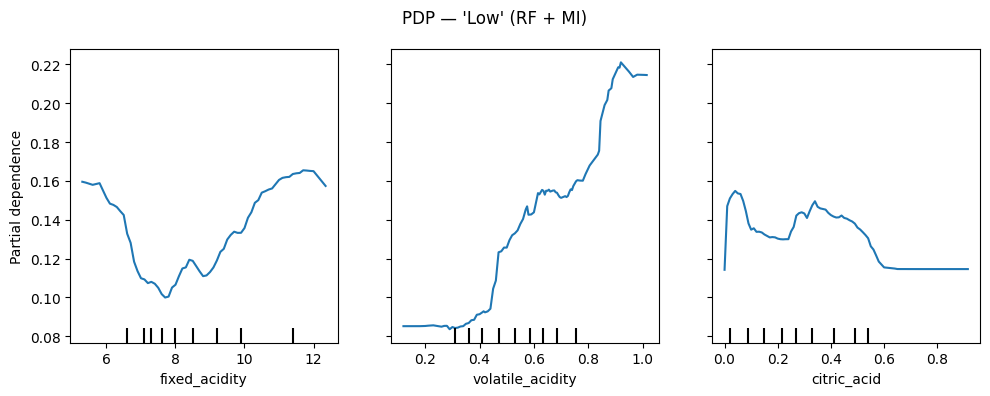

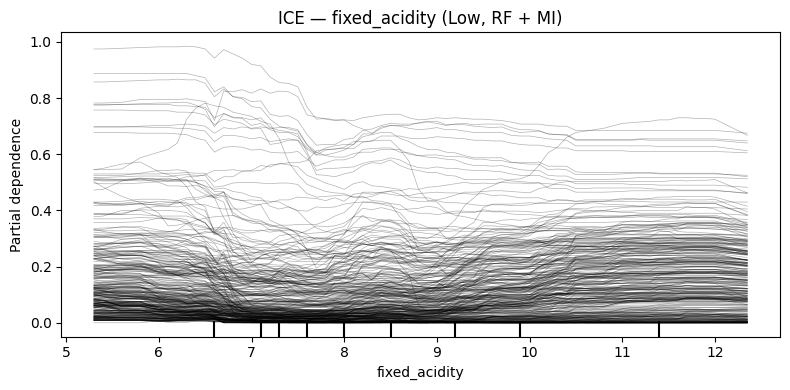

In [25]:
#Visual Explanation with PDP and ICE on best so far 
# Which features were actually selected?
sel = champ_mi.named_steps["sel"]
mask = sel.get_support()
feat_names = np.array(X_train.columns)[mask]
top_feats = feat_names[:3]

fig, ax = plt.subplots(figsize=(10,4))
PartialDependenceDisplay.from_estimator(champ_mi, X_test, features=top_feats, target=0, kind="average", ax=ax)
plt.suptitle("PDP — 'Low' (RF + MI)"); plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(8,4))
PartialDependenceDisplay.from_estimator(champ_mi, X_test, features=[top_feats[0]], target=0,
                                        kind="individual", ice_lines_kw={"alpha":0.3}, line_kw={"color":"black"}, ax=ax)
plt.title(f"ICE — {top_feats[0]} (Low, RF + MI)"); plt.tight_layout(); plt.show()

In [26]:
#Shap Explaniner
sel, sca, rf = (champ_mi.named_steps["sel"], champ_mi.named_steps["scaler"], champ_mi.named_steps["clf"])
feat_names  = np.array(X_train.columns)[sel.get_support()]
Xte_scaled  = sca.transform(sel.transform(X_test))

explainer   = shap.TreeExplainer(rf)  # raw output
sv          = explainer.shap_values(Xte_scaled)  # list[3] for Low/Med/High

def _align(sv_class, X):
    return sv_class[:, :-1] if sv_class.shape[1] == X.shape[1] + 1 else sv_class
sv = [ _align(s, Xte_scaled) for s in sv ]

for c, cname in enumerate(["Low","Medium","High"]):
    shap.summary_plot(sv[c], Xte_scaled, feature_names=feat_names, plot_type="bar", show=True)
    shap.summary_plot(sv[c], Xte_scaled, feature_names=feat_names, show=True)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

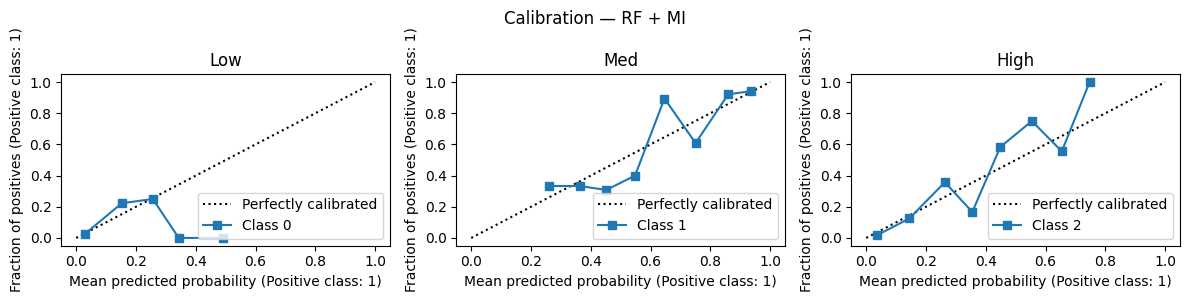

              precision    recall  f1-score   support

         Low       0.00      0.00      0.00        11
      Medium       0.90      0.93      0.92       264
        High       0.61      0.62      0.62        40

    accuracy                           0.86       315
   macro avg       0.50      0.52      0.51       315
weighted avg       0.84      0.86      0.85       315

Total expected cost: 156.5 | Avg per sample: 0.497


In [30]:
#Calibration + cost sensitive decicions


rf_estimator_mi = make_poly_selector_pipeline(models["RF"], selector="mi", use_poly=False)
cal_mi = CalibratedClassifierCV(estimator=rf_estimator_mi, method="sigmoid", cv=5)
cal_mi.fit(X_train, y_train)
probs = cal_mi.predict_proba(X_test)

# Reliability
Y_bin = label_binarize(y_test, classes=[0,1,2])
fig, axs = plt.subplots(1,3, figsize=(12,3))
for c in range(3):
    CalibrationDisplay.from_predictions(Y_bin[:,c], probs[:,c], n_bins=10, name=f"Class {c}", ax=axs[c])
    axs[c].set_title(["Low","Med","High"][c])
plt.suptitle("Calibration — RF + MI"); plt.tight_layout(); plt.show()

# Cost-sensitive Bayes decision
C = np.array([[0.0, 6.0, 8.0],[3.0, 0.0, 2.0],[5.0, 3.5, 0.0]])
y_pred_cost = (probs @ C).argmin(axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_cost, target_names=["Low","Medium","High"]))

# Safe total cost
y_true = np.asarray(y_test, dtype=int)
sample_costs = C[y_true, y_pred_cost]
print("Total expected cost:", sample_costs.sum(), "| Avg per sample:", sample_costs.mean().round(3))

What the calibration plots say

Low (class 0): almost all predicted probs are < 0.30 and the curve is noisy → the model is under-confident and rarely assigns meaningful probability to Low.

Medium (class 1): fairly well-calibrated in 0.6–1.0; the model is confident and usually correct.

High (class 2): a bit under-confident for 0.4–0.7 (curve above diagonal), then close to diagonal >0.7.
